# Sparkify

In [1]:
# Import Libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql import functions as f
from pyspark.sql.types import IntegerType

from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

from functools import reduce
from sklearn.metrics import roc_curve

import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190728164858-0001
KERNEL_ID = 92072bdf-8286-4a23-8805-975a18c64851


In [5]:
# The code was removed by Watson Studio for sharing.

In [ ]:
spark = SparkSession.builder.getOrCreate()

## Load the Dataset

In [6]:
df = spark.read.json(cos.url('medium-sparkify-event-data.json', 'dsndsparkify-donotdelete-pr-embi84be1iv43s'))
df.head()

Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293')

## Exploratory Data Analysis

In [7]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
print("Shape:", (df.count(), len(df.columns)))

Shape: (543705, 18)


In [11]:
# Count number of null entries by column
df.select(
    [
        f.count(
            f.when(
                f.isnan(c) | f.col(c).isNull(), 
                c
            )
        ).alias(c) for c in df.columns
    ]
).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|  song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+
|110828|   0|    15700| 15700|            0|   15700|110828|    0|   15700|     0|   0|       15700|        0|110828|     0|  0|    15700|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+------+------+---+---------+------+



In [12]:
# Show pages visited with no user information
df.select(
    f.when(
        f.isnan('userAgent') | f.col('userAgent').isNull(),
        f.col('page')
    ).alias('page')
).dropDuplicates().show()

+-------------------+
|               page|
+-------------------+
|               Home|
|               null|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



### Finding
15700 entries contain no user information.  These appear to be users who either have not registered yet or are not logged in.  Because we are only interested in users who are registered (and at risk for churn), we can safely remove these entries.  Artist, length, and song show 110828 null entries, as they are only present for certain page actions.

In [13]:
# Sample `ts` column
df.select('ts').head()

Row(ts=1538352011000)

### Finding
The `ts` column is a UNIX timestamp at the millisecond level.  We can use this for time series analysis, but creating human-readable versions of timestamp and datestamp may be helpful.

In [14]:
# Drop unregistered users
df = df.where(df["userAgent"].isNotNull())

In [15]:
# Count of actions by gender
df.groupBy('gender').count().show()

+------+------+
|gender| count|
+------+------+
|     F|225393|
|     M|302612|
+------+------+



### Finding
Pages actions skew slightly towards male users with 57% of total actions.

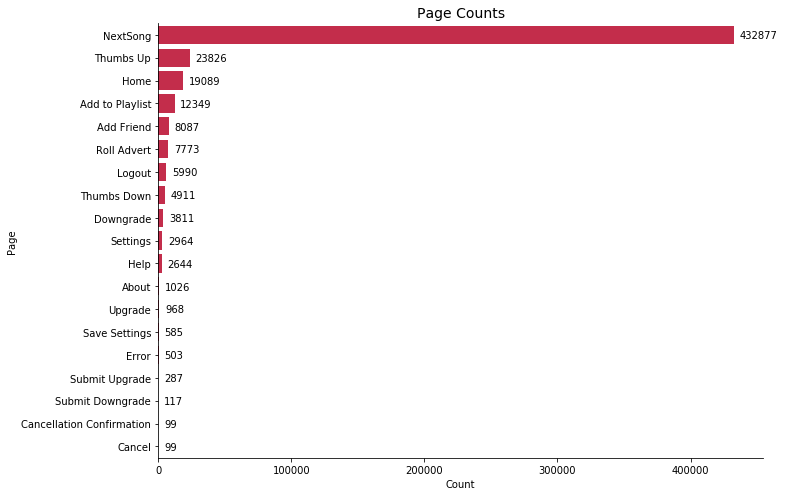

In [17]:
# Retrieve counts of page actions
page_counts = pd.DataFrame(
    df.groupBy('page').count().collect(), columns=["page", "page_count"]
).sort_values(
    by='page_count', ascending=False
).reset_index()

# Instantiate plot
fig, ax = plt.subplots(1, 1, figsize=(11, 7))

# Plot bar chart
sns.barplot(data=page_counts, y='page', x='page_count', ax=ax, color='crimson')

# Annotate with count values
max_count = page_counts['page_count'].max()
for i, v in page_counts.iterrows():
    label = v.page_count
    ax.text(v.page_count+(max_count*0.01), i+0.15, label, color='black')

# Format chart
ax.set_ylabel("Page")
ax.set_xlabel("Count")
ax.set_title("Page Counts", fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### Finding
The vast majority of page actions are users playing songs on the platform.  As well, there are only 99 cancellations within the data set.  This is problemmatic for our modeling.  We will need to choose a tact that emphasizes finding positive chases (churns).  This makes sense for our business problem as well.  Not identifying user churns is more costly than falsely identifying ones.

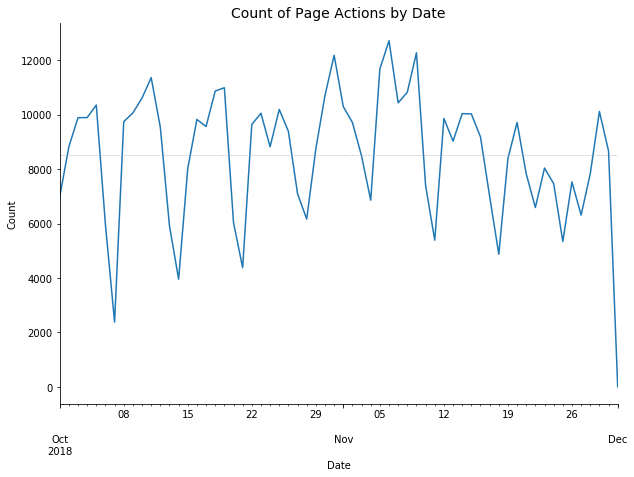

In [24]:
# Convert timestamp
to_time_string = f.udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn('timestamp', f.to_timestamp(to_time_string(df['ts'])))

# Roll up to datestamp
df = df.withColumn('datestamp', df['timestamp'].cast('date'))

# Create date series
date_series_df = df.groupBy('datestamp').count().sort('datestamp', ascending=True).toPandas()
date_series_df['datestamp'] = pd.to_datetime(date_series_df['datestamp'])
date_series_df.set_index('datestamp', inplace=True)

# Calculate average
action_avg = date_series_df.mean()[0]

# Instantiate plot
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

# Plot time series chart
date_series_df.plot(ax=ax, legend=False)

# Plot average
ax.axhline(action_avg, color='darkgrey', linestyle='--', linewidth=0.5)

# Format chart
ax.set_ylabel("Count")
ax.set_xlabel("Date")
ax.set_title("Count of Page Actions by Date", fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

### Finding
The data set is over a two month period, only.  This will limit our windows of analysis, and speaks to the low amount of cancellations contained within the data set.

## Defining Churn
Notifications of potential churn should receive quick, and perhaps automated response.  Because of this, recreating a data set from scratch any time new data arrives is likely too cumbersome.  Analyzing the data in a state close to its natural form allows for quicker predictions and rapid response.  This means our churn flag must be forward-looking based on timestamp.

Likewise, the churn prediction must come early enough to allow for a response.  Predicting the next page a user will visit is the cancellation page is not actionable.  Predicting "churn within the next 3 days" allows a response to be initiated in time to (hopefully) prevent the loss.

In [25]:
# Order dataframe by userId and timestamp
df = df.orderBy("userId", "ts")

# Function to convert milliseconds to days
days = lambda x: x * (1000 * 60 * 60 * 24)

# Flag cancellation within the next 3 days
churn_window = Window.partitionBy(df['userId']).orderBy(df['ts']).rangeBetween(0, days(3))

df = df.withColumn(
    "impending_churn", f.max(f.when(df.page == "Cancellation Confirmation", 1).otherwise(0)).over(churn_window)
)

In [26]:
# Collect userIds for users who churned
users_that_churned = df.filter(df['impending_churn'] == 1).select('userId').dropDuplicates().collect()
users_that_churned_ids = [i.userId for i in users_that_churned]

# Isolate page actions for users that churned
churned = df.filter(df['userId'].isin(users_that_churned_ids))

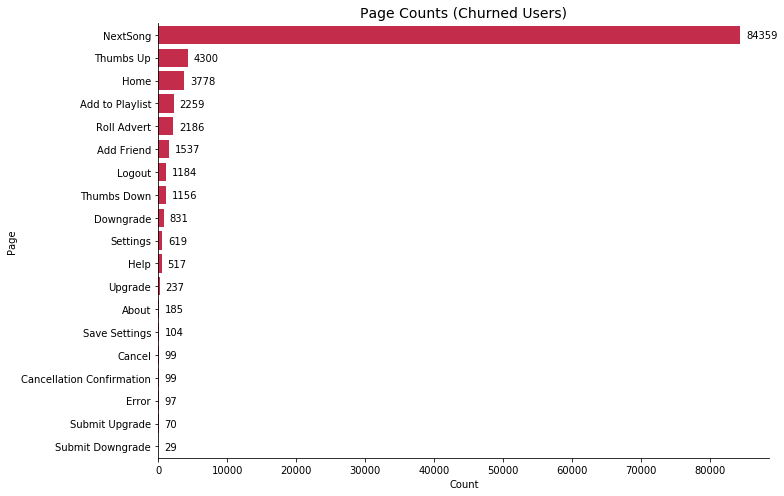

In [27]:
# Retrieve counts of page actions
page_counts_churn = pd.DataFrame(
    churned.groupBy('page').count().collect(), columns=["page", "page_count"]
).sort_values(
    by='page_count', ascending=False
).reset_index()

# Instantiate plot
fig, ax = plt.subplots(1, 1, figsize=(11, 7))

# Plot bar chart
sns.barplot(data=page_counts_churn, y='page', x='page_count', ax=ax, color='crimson')

# Annotate with count values
max_count = page_counts_churn['page_count'].max()
for i, v in page_counts_churn.iterrows():
    label = v.page_count
    ax.text(v.page_count+(max_count*0.01), i+0.15, label, color='black')

# Format chart
ax.set_ylabel("Page")
ax.set_xlabel("Count")
ax.set_title("Page Counts (Churned Users)", fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [28]:
# Count of actions by gender
churned.groupBy('gender').count().show()

+------+-----+
|gender|count|
+------+-----+
|     F|48238|
|     M|55408|
+------+-----+



### Findings
- The distribution of page views among churned users largely reflects that of the whole population.  Because of this, counting only the aggregate page views for a user is likely not enough information to predict possible churn.  However, looking at smaller windows may better inform us.
- The gender distribution in page actions for churned users shifts slightly from the general population.  We now see 53% of page actions come from male users.

## Feature Engineering

Initial EDA suggests maintaining the timeseries format of the data set may be our best tact.  We will attempt to engineer features that lean in to this by collecting additional information from the timestamp and using rolling windows to summarize recent actions.

Data points to develop:
- Time Features
   - Hour, Day, Month, Year of action
- Days Since Registration
- Gender (binary column)
- Subscription Status (binary column)
- Page Action (binary column for each page type)
- Rolling Windows (1, 7, and 30 days)
   - Summary of each page action within each rolling window

In [30]:
# Create hour / day / month / year fields
df = df.withColumn("hour", f.hour("timestamp"))
df = df.withColumn("day", f.dayofmonth("timestamp"))
df = df.withColumn("month", f.month("timestamp"))
df = df.withColumn("year", f.year("timestamp"))

def days_since_reg(x, y):
    """
    Retrieve rounded number of days since registration
    """
    sec_diff = f.when(x > y, x - y).otherwise(0)    
    return f.round(sec_diff / (1000 * 60 * 60 * 24))


# Days since registration
df = df.withColumn(
    'days_since_reg', days_since_reg(df.ts, df.registration)
)

# Convert gender to binary column
df = df.withColumn('gender_male', f.when(df.gender == 'M', 1).otherwise(0))

# Convert subscription level to binary column
df = df.withColumn('paid_level', f.when(df.level == 'paid', 1).otherwise(0))

# List of unique page entries
pages = [row.page for row in df.select(df.page).dropDuplicates().collect()]

for page in pages:
    
    # Flag matching pages
    page_col = page.replace(" ", "")+"_page"
    df = df.withColumn(page_col, f.when(df.page == page, 1).otherwise(0))
    
    # for 1, 7, and 30 day intervals...
    for i in [1, 7, 30]:
                
        # Rolling window funciton for i days
        w = (Window().partitionBy(df['userId']).orderBy(df['ts']).rangeBetween(-days(i), 0))

        # Create column counting sum of page events in rolling window
        window_col = page.replace(" ", "") + "_last{}d".format(i)
        df = df.withColumn(window_col, f.sum(page_col).over(w))

In [31]:
df.head()

Row(artist='Darude', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=226.08934, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=62, song='Sandstorm', status=200, ts=1538991392000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', timestamp=datetime.datetime(2018, 10, 8, 9, 36, 32), datestamp=datetime.date(2018, 10, 8), impending_churn=0, hour=9, day=8, month=10, year=2018, days_since_reg=11.0, gender_male=0, paid_level=0, Cancel_page=0, Cancel_last1d=0, Cancel_last7d=0, Cancel_last30d=0, SubmitDowngrade_page=0, SubmitDowngrade_last1d=0, SubmitDowngrade_last7d=0, SubmitDowngrade_last30d=0, ThumbsDown_page=0, ThumbsDown_last1d=0, ThumbsDown_last7d=0, ThumbsDown_last30d=0, Home_page=0, Home_last1d=0, Home_last7d=0, Home_last30d=0, Downgrade_pag

## Modeling

In [32]:
# Create features vector
exclude_cols = ['artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName', 'length',
                'level', 'location', 'method', 'page', 'registration', 'sessionId', 'song', 'status',
                'ts', 'userAgent', 'userId', 'timestamp', 'datestamp', 'id', 'impending_churn', 
                'CancellationConfirmation_page', 'CancellationConfirmation_last1d', 
                'CancellationConfirmation_last7d', 'CancellationConfirmation_last30d']
feature_cols = [x for x in df.columns if x not in exclude_cols]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="raw_features")
df = assembler.transform(df)

In [33]:
# Isolate feature and label columns
data = df.select(df["impending_churn"].alias("label"), df["raw_features"])

# Split code for training / validation
train, test = data.randomSplit([0.6, 0.4], seed=99)

In [52]:
# Instantiate standard scaler
scaler = StandardScaler(inputCol="raw_features", outputCol="features", withStd=True)

# Instantiate classifier
gbc = GBTClassifier(lossType='logistic', seed=99)

pipeline = Pipeline(stages=[scaler, gbc])

In [53]:
model = pipeline.fit(train)

In [54]:
preds = model.transform(test)

## Model Evaluation

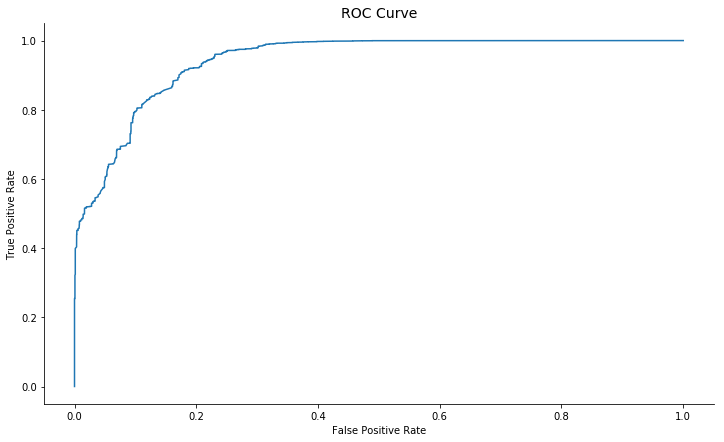

In [55]:
# Collect label and probability values
preds_list = preds.select('label','probability')\
    .rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))\
    .collect()

# Pass through roc_curve function
y_score, y_true = zip(*preds_list)
y_score_rev = [1 - x for x in y_score]
fpr, tpr, thresholds = roc_curve(y_true, y_score_rev, pos_label = 1)

# Plot ROC Curve
fig, ax = plt.subplots(1, 1, figsize=(12,7))
ax.plot(tpr, fpr)

# Format chart
ax.set_ylabel("True Positive Rate")
ax.set_xlabel("False Positive Rate")
ax.set_title("ROC Curve", fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

In [56]:
roc_dict = {'threshold': thresholds,
            'true_positive_rate': tpr,
            'false_positive_rate': fpr}
df = pd.DataFrame.from_dict(roc_dict)
cut_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
df.groupby(pd.cut(df.threshold,cut_list).astype(str))['true_positive_rate', 'false_positive_rate'].max().reset_index()

,threshold,true_positive_rate,false_positive_rate
0,"(0.0, 0.1]",1.000000,1.000000
1,"(0.1, 0.2]",0.979017,1.000000
2,"(0.2, 0.3]",0.841994,0.999961
3,"(0.3, 0.4]",0.805802,0.999951
4,"(0.4, 0.5]",0.745810,0.999951
5,"(0.5, 0.6]",0.667934,0.999951
6,"(0.6, 0.7]",0.631601,0.999853
7,"(0.7, 0.8]",0.564991,0.999853
8,"(0.8, 0.9]",0.532319,0.999740
9,"(0.9, 1.0]",0.329813,0.991190


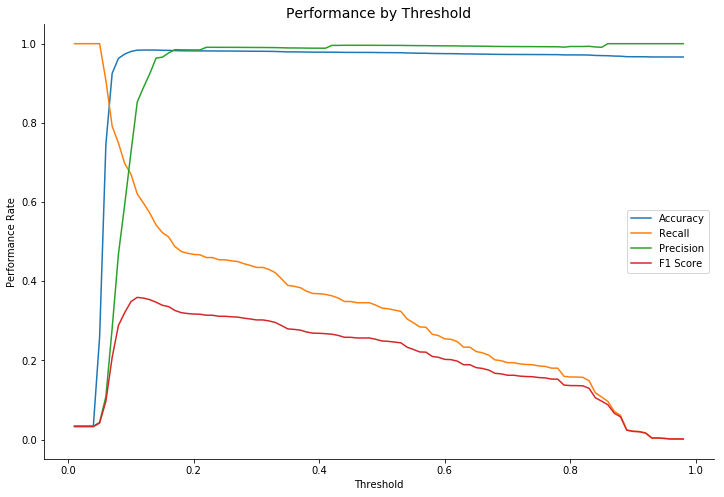

In [57]:
# Convert predictions to a dataframe
preds_df = pd.DataFrame({'preds': y_score, 'label': y_true})

# Iterate over possible thresholds and capture metrics for each
thresholds = [x / 100.0 for x in list(range(1,99))]
accuracy = []
recall = []
precision = []
f1_score = []

for t in thresholds:
    tp = len(preds_df.query(f"label == 1 and preds >= {t}"))
    fp = len(preds_df.query(f"label == 0 and preds >= {t}"))
    tn = len(preds_df.query(f"label == 0 and preds < {t}"))
    fn = len(preds_df.query(f"label == 1 and preds < {t}"))
    
    acc = (tp+tn)/(tp+fp+tn+fn)
    rec = tp / (tp+fn)

    try:
        prec = tp / (tp+fp)
    except ZeroDivisionError:
        prec = 0
    
    try:
        f1 = (prec * rec) / (prec + rec)
    except:
        f1 = 0
    
    accuracy.append(acc)
    recall.append(rec)
    precision.append(prec)
    f1_score.append(f1)
    
# Plot Accuracy / Recall / Precision
fig, ax = plt.subplots(1, 1, figsize=(12,8))
ax.plot(thresholds, accuracy, label='Accuracy')
ax.plot(thresholds, recall, label='Recall')
ax.plot(thresholds, specificity, label="Specificity")
ax.plot(thresholds, precision, label='Precision')
ax.plot(thresholds, f1_score, label="F1 Score")

# Format chart
ax.set_ylabel("Performance Rate")
ax.set_xlabel("Threshold")
ax.set_title("Performance by Threshold", fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend()
plt.show()

### References
Barranka. “PySpark: Get Threshold (Cuttoff) Values for Each Point in ROC Curve.” Stack Overflow, 1 July 1969, stackoverflow.com/questions/54425084/pyspark-get-threshold-cuttoff-values-for-each-point-in-roc-curve.

“Gradient Boosting.” Wikipedia, Wikimedia Foundation, 30 May 2019, en.wikipedia.org/wiki/Gradient_boosting.

Patel, Neil. “How to Improve Your Subscription Based Business by Predicting Churn.” Neil Patel, 24 May 2019, neilpatel.com/blog/improve-by-predicting-churn/.

“Receiver Operating Characteristic.” Wikipedia, Wikimedia Foundation, 11 July 2019, en.wikipedia.org/wiki/Receiver_operating_characteristic.

Safdari, Nasir. “Build an End-to-End Machine Learning Model with MLlib in PySpark.” Medium, Towards Data Science, 13 Feb. 2019, towardsdatascience.com/build-an-end-to-end-machine-learning-model-with-mllib-in-pyspark-4917bdf289c5.

Tausend, F. “Hands-on: Predict Customer Churn.” Medium, Towards Data Science, 1 June 2019, towardsdatascience.com/hands-on-predict-customer-churn-5c2a42806266.
